In [1]:
import numpy as np
import matplotlib.pyplot as plt
from IPython import display
import PIL
import imageio
import os
import time
import glob

In [2]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Conv2DTranspose, BatchNormalization, LeakyReLU, Reshape, Dropout, Conv2D, Flatten

We will first download the mnist dataset and preprocess the data. Our data will be in the range [-1, 1].

In [3]:
(X_train, y_test), (_, _) = tf.keras.datasets.mnist.load_data()
X_train = (X_train.reshape(X_train.shape[0], 28, 28, 1).astype('float32') - 127.5) / 127.5

11493376/11490434 [==============================] - 0s 0us/step


In [4]:
BUFFER_SIZE = len(X_train)
BATCH_SIZE = 256
train_dataset = tf.data.Dataset.from_tensor_slices(X_train).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

Our generator model consists mostly of Deconvolutional layers or in other words Transposed Convolutional layers. The main goal of the deconvolutional layers is the reverse of a convolutional operation. 

In [5]:
def make_generator():
  model = tf.keras.Sequential()
  model.add(Dense(7*7*256, use_bias=False, input_shape=(100,)))
  model.add(BatchNormalization())
  model.add(LeakyReLU())

  model.add(Reshape((7, 7, 256)))
  assert model.output_shape == (None, 7, 7, 256) # Note: None is the batch size

  model.add(Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
  assert model.output_shape == (None, 7, 7, 128)
  model.add(BatchNormalization())
  model.add(LeakyReLU())

  model.add(Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
  assert model.output_shape == (None, 14, 14, 64)
  model.add(BatchNormalization())
  model.add(LeakyReLU())

  model.add(Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
  assert model.output_shape == (None, 28, 28, 1)

  return model

Let's see what our generator can create without training. Bellow is an image that our generator created. We can see that it is just a bunch of pixels with a random value between 0 and 255, often called 'noise'.

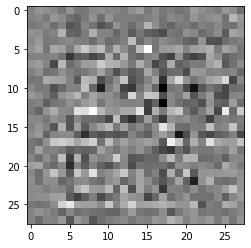

In [6]:
generator = make_generator()

noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)
plt.imshow(generated_image[0, :, :, 0], cmap='gray')

Now we will create the second player, the discriminator. The discriminator is just a binary classifier that consists mostly of convolutional layers. It's goal is to predict if the image is real or not.

In [7]:
def make_discriminator():
  model = tf.keras.Sequential()
  model.add(Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[28, 28, 1]))
  model.add(LeakyReLU())
  model.add(Dropout(0.3))

  model.add(Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
  model.add(LeakyReLU())
  model.add(Dropout(0.3))

  model.add(Flatten())
  model.add(Dense(1))

  return model

Let's see what our not trained discriminator will predict for the image, noise, we created earlier. It predicted correct, values 0 are false.

In [8]:
discriminator = make_discriminator()
decision =discriminator(generated_image)
print(decision)

tf.Tensor([[0.00048014]], shape=(1, 1), dtype=float32)


Since this is a binary classification problem, the loss function would be Binary Crossentropy. But this loss is adjusted and applied to both the networks separately.

In [9]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

The generator is trying to generate images that the discriminator would approve as real images. So the generated images must be predicted as 1 and if not they must be penalized for failing to do so.

In [10]:
def generator_loss(fake):
  return cross_entropy(tf.ones_like(fake), fake)

On the other hand the discriminator want itself to predict generated images as fake and also all of the real images as real. The discriminator trains on a combination of these two losses.

In [11]:
def discriminator_loss(real, fake):
  real_loss = cross_entropy(tf.ones_like(real), real)
  fake_loss = cross_entropy(tf.zeros_like(fake), fake)
  total_loss = real_loss + fake_loss  
  return total_loss

We are going to create seperate optimizers for both networks. 

In [12]:
generator_opt = tf.keras.optimizers.Adam(1e-4)
discriminator_opt = tf.keras.optimizers.Adam(1e-4)

Train the network for 50 epochs. In the training epoch we process the generator and discriminator together. However, we apply the gradients separately as the losses and the architectures of both the models are different.

In [13]:
epochs = 50
noise_dim = 100
num_examples_to_generate = 16

seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [14]:
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      gen = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(gen, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_opt.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_opt.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [15]:
def generate_and_save_images(model, epoch, test_input):
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4, 4))

  for i in range(predictions.shape[0]):
    plt.subplot(4, 4, i+1)
    plt.imshow(predictions[i, :, :, 0] * 127.5  + 127.5, cmap='gray')
    plt.axis('off')

  plt.savefig(f"image_0{epoch:4d}.png")
  plt.show()

In [16]:
def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      train_step(image_batch)
    
    display.clear_output(wait=True)
    generate_and_save_images(generator, epoch+1, seed)

    print(f"Time needed for epoch {epoch+1} is {time.time() - start} sec")

  display.clear_output(wait=False)
  generate_and_save_images(generator, epochs, seed)

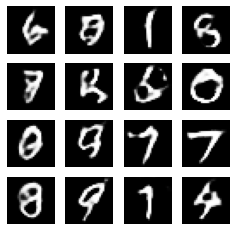

In [17]:
train(train_dataset, epochs)

In [18]:
# Display a single image using the epoch number
def display_image(epoch_no):
  return PIL.Image.open('image_0{:4d}.png'.format(epoch_no))

In [19]:
anim_file = 'dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('image*.png')
  filenames = sorted(filenames)
  last = -1
  for i,filename in enumerate(filenames):
    frame = 2*(i**0.5)
    if round(frame) > round(last):
      last = frame
    else:
      continue
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)

import IPython
if IPython.version_info > (6,2,0,''):
  display.Image(filename=anim_file)